<a href="https://colab.research.google.com/github/dornercr/DSCI631/blob/main/DSCI631_alternate_example_week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Theory
Reproducibility is a core principle: every run should give the same result.  
Randomness appears in splits, initialization, and sampling.  
Setting a seed makes this deterministic.  

Libraries we’ll use:  
- NumPy: numerical arrays.  
- Pandas: tabular data.  
- Matplotlib: visualizations.  
- Scikit-learn: preprocessing, models, metrics.  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin

np.random.seed(42)


### Theory
We construct a toy dataset of 20 students with:  
- study_hours (numeric)  
- absences (numeric)  
- parent_education (categorical)  
- gender (categorical)  
- final_score (target, numeric)  

Auditing ensures columns, datatypes, and missing values are clear.  


In [ ]:
data = {
    "study_hours": [2, 5, 7, 1, 3, 8, 4, 6, 9, 2, 3, 10, 5, 6, 7, 8, 9, 4, 2, 1],
    "absences": [3, 2, 0, 5, 1, 0, 2, 1, 0, 4, 3, 0, 2, 1, 0, 0, 0, 2, 4, 5],
    "parent_education": ["high_school","bachelor","bachelor","high_school","master",
                         "master","high_school","bachelor","phd","high_school",
                         "bachelor","phd","master","bachelor","bachelor","master",
                         "phd","high_school","high_school","high_school"],
    "gender": ["F","M","M","F","F","M","F","M","M","F","M","M","F","M","M","F","F","F","M","F"],
    "final_score": [60, 70, 85, 50, 65, 90, 55, 75, 95, 58, 62, 98, 72, 80, 83, 89, 94, 61, 59, 45]
}

students = pd.DataFrame(data)
students.info()
students.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   study_hours       20 non-null     int64 
 1   absences          20 non-null     int64 
 2   parent_education  20 non-null     object
 3   gender            20 non-null     object
 4   final_score       20 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 932.0+ bytes


,study_hours,absences,parent_education,gender,final_score
0,2,3,high_school,F,60
1,5,2,bachelor,M,70
2,7,0,bachelor,M,85
3,1,5,high_school,F,50
4,3,1,master,F,65


### Theory
- `value_counts()` checks balance of categorical variables.  
- `describe()` shows summary stats for numeric columns.  
- Histograms reveal skew, caps, and spread.  


parent_education
high_school    7
bachelor       6
master         4
phd            3
Name: count, dtype: int64
gender
F    10
M    10
Name: count, dtype: int64


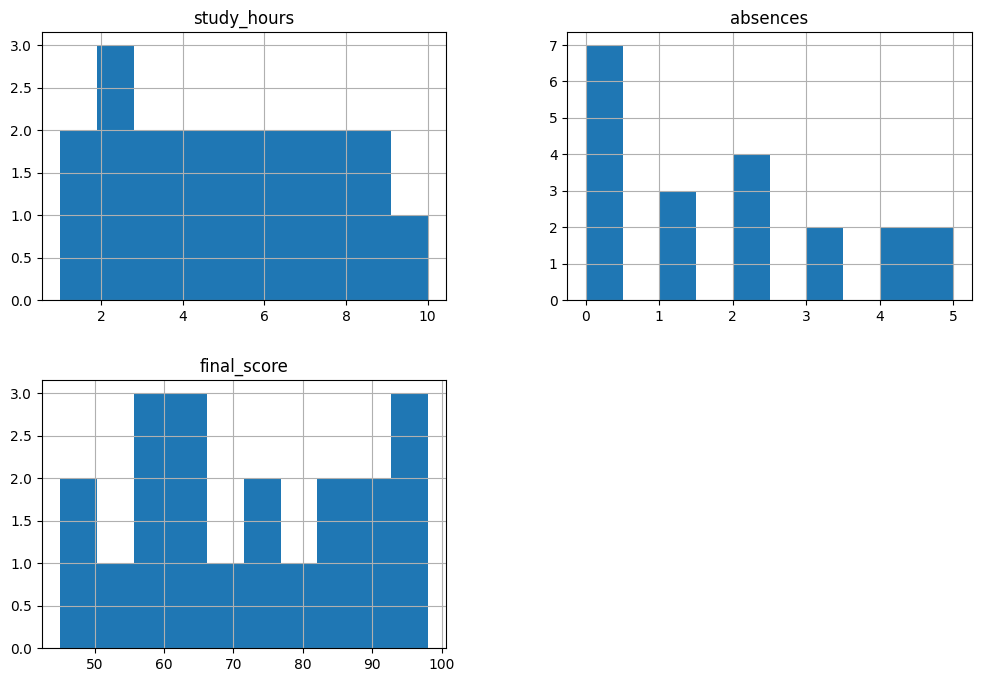

In [ ]:
print(students["parent_education"].value_counts())
print(students["gender"].value_counts())

students.describe()

students.hist(bins=10, figsize=(12,8))
plt.show()


### Theory
Always split early to avoid leakage.  
The test set simulates unseen data, like a final exam.  
Use a fixed seed for reproducibility.  


In [ ]:
train_set, test_set = train_test_split(students, test_size=0.2, random_state=42)
train_set.head()


,study_hours,absences,parent_education,gender,final_score
8,9,0,phd,M,95
5,8,0,master,M,90
11,10,0,phd,M,98
3,1,5,high_school,F,50
18,2,4,high_school,M,59


### Theory
If a categorical feature is imbalanced but important, stratify.  
Here, parent education is strongly linked to outcomes, so we stratify.  


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(students, students["parent_education"]):
    strat_train_set = students.loc[train_idx]
    strat_test_set = students.loc[test_idx]

strat_test_set["parent_education"].value_counts(normalize=True)


,proportion
parent_education,
high_school,0.25
bachelor,0.25
phd,0.25
master,0.25


### Theory
EDA reveals relationships:  
- Study hours should correlate positively with scores.  
- Absences should correlate negatively.  
- Categorical features add structure (education, gender).  


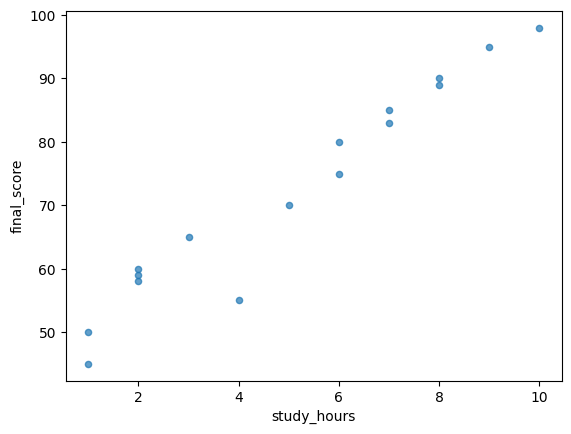

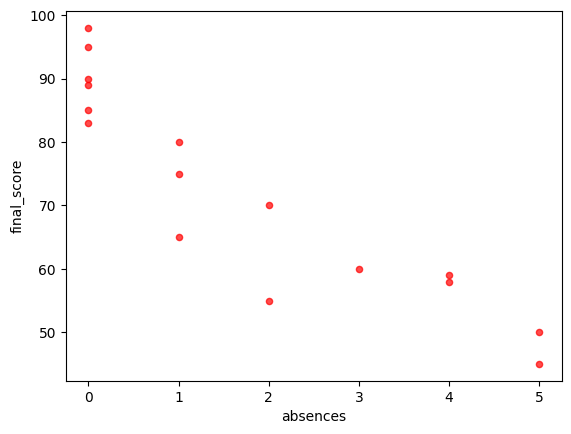

study_hours    0.971526
absences      -0.910407
final_score    1.000000
Name: final_score, dtype: float64


In [ ]:
train = strat_train_set.copy()

train.plot(kind="scatter", x="study_hours", y="final_score", alpha=0.7)
plt.show()

train.plot(kind="scatter", x="absences", y="final_score", alpha=0.7, color="red")
plt.show()

print(train.corr(numeric_only=True)["final_score"])


### Theory
Ratios and transformations can expose hidden structure.  
Example: “efficiency” = study_hours / (1 + absences).  
To keep preprocessing consistent, we add it inside the pipeline.  


In [ ]:
class EfficiencyAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X["efficiency"] = X["study_hours"] / (1 + X["absences"])
        return X


### Theory
Prevent leakage by separating labels.  
Preprocessing (imputation, scaling, encoding) must only use features.  


In [ ]:
train_features = strat_train_set.drop("final_score", axis=1)
train_labels = strat_train_set["final_score"].copy()


### Theory
Missing values can be dropped or imputed.  
Here, we’ll pretend absences has missing values and impute with median.  


In [ ]:
train_features.loc[train_features.sample(2).index, "absences"] = np.nan  # fake missing


### Theory
- Numeric pipeline: add efficiency → impute → scale.  
- Categorical pipeline: one-hot encode categories.  
- ColumnTransformer merges them into one pipeline.  


In [ ]:
num_attribs = ["study_hours","absences"]  # efficiency will be added inside pipeline
cat_attribs = ["parent_education","gender"]

num_pipeline = Pipeline([
    ("efficiency_adder", EfficiencyAdder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

train_prepared = full_pipeline.fit_transform(train_features)
train_prepared.shape


(16, 9)

### Theory
Baseline models set expectations.  
Linear regression is interpretable but may underfit.  
Metrics: RMSE, MAE.  


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

train_preds = lin_reg.predict(train_prepared)
rmse = np.sqrt(mean_squared_error(train_labels, train_preds))
mae = mean_absolute_error(train_labels, train_preds)
rmse, mae


(np.float64(2.8030690773962053), 2.301841574294521)

### Theory
Trees can fit non-linear patterns.  
But unconstrained trees often overfit (training error = 0).  


In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_prepared, train_labels)

tree_preds = tree_reg.predict(train_prepared)
tree_rmse = np.sqrt(mean_squared_error(train_labels, tree_preds))
tree_rmse


np.float64(1.25)

### Theory
The test set simulates future unseen data.  
Always evaluate once, at the end.  


In [ ]:
test_features = strat_test_set.drop("final_score", axis=1)
test_labels = strat_test_set["final_score"].copy()

test_prepared = full_pipeline.transform(test_features)

final_preds = lin_reg.predict(test_prepared)
final_rmse = np.sqrt(mean_squared_error(test_labels, final_preds))
final_mae = mean_absolute_error(test_labels, final_preds)
final_rmse, final_mae


(np.float64(2.9500331576259033), 2.5704095401258513)

### Checklist
1. Setup reproducibility.  
2. Load and audit dataset.  
3. Split early; stratify if needed.  
4. Train-only EDA.  
5. Feature engineering.  
6. Separate labels.  
7. Build pipelines for preprocessing.  
8. Train a baseline model.  
9. Try flexible models.  
10. Evaluate once on the untouched test set.  
